In [1]:
import torch
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
from torch.autograd import Variable

from sklearn.preprocessing import OneHotEncoder
import os, math, glob, argparse
from utils.torch_utils import *
from utils.utils import *
from mpradragonn_predictor_pytorch import *
import matplotlib.pyplot as plt
import utils.language_helpers
#plt.switch_backend('agg')
import numpy as np
from models import *

from wgan_gp_mpradragonn_analyzer_quantile_cutoff import *

use_cuda = torch.cuda.is_available()
device = torch.device('cuda:0' if use_cuda else 'cpu')

from torch.distributions import Normal as torch_normal

class IdentityEncoder :
    
    def __init__(self, seq_len, channel_map) :
        self.seq_len = seq_len
        self.n_channels = len(channel_map)
        self.encode_map = channel_map
        self.decode_map = {
            nt: ix for ix, nt in self.encode_map.items()
        }
    
    def encode(self, seq) :
        encoding = np.zeros((self.seq_len, self.n_channels))
        
        for i in range(len(seq)) :
            if seq[i] in self.encode_map :
                channel_ix = self.encode_map[seq[i]]
                encoding[i, channel_ix] = 1.

        return encoding
    
    def encode_inplace(self, seq, encoding) :
        for i in range(len(seq)) :
            if seq[i] in self.encode_map :
                channel_ix = self.encode_map[seq[i]]
                encoding[i, channel_ix] = 1.
    
    def encode_inplace_sparse(self, seq, encoding_mat, row_index) :
        raise NotImplementError()
    
    def decode(self, encoding) :
        seq = ''
    
        for pos in range(0, encoding.shape[0]) :
            argmax_nt = np.argmax(encoding[pos, :])
            max_nt = np.max(encoding[pos, :])
            seq += self.decode_map[argmax_nt]

        return seq
    
    def decode_sparse(self, encoding_mat, row_index) :
        raise NotImplementError()



/home/ubuntu/anaconda3/envs/pytorch_p36_fbgan/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:

class ActivationMaximizer(nn.Module) :
    
    def __init__(self, generator_dir, batch_size=1, seq_len=145, latent_size=128, sequence_template=None):
        super(ActivationMaximizer, self).__init__()
        self.generator = Generator_lang(4, seq_len, batch_size, 512)
        self.predictor = DragoNNClassifier(batch_size=batch_size).cnn
        
        self.load_generator(generator_dir)
        
        self.use_cuda = torch.cuda.is_available()
        
        self.x_mask = None
        self.x_template = None
        if sequence_template is not None :
            onehot_mask = np.zeros((seq_len, 4))
            onehot_template = np.zeros((seq_len, 4))

            for j in range(len(sequence_template)) :
                if sequence_template[j] == 'N' :
                    onehot_mask[j, :] = 1.
                elif sequence_template[j] == 'A' :
                    onehot_template[j, 0] = 1.
                elif sequence_template[j] == 'C' :
                    onehot_template[j, 1] = 1.
                elif sequence_template[j] == 'G' :
                    onehot_template[j, 2] = 1.
                elif sequence_template[j] == 'T' :
                    onehot_template[j, 3] = 1.
            
            self.x_mask = Variable(torch.FloatTensor(onehot_mask).unsqueeze(0))
            self.x_template = Variable(torch.FloatTensor(onehot_template).unsqueeze(0))
            if self.use_cuda :
                self.x_mask = self.x_mask.to(device)
                self.x_template = self.x_template.to(device)
        
        self.predictor.eval()
        
        if self.use_cuda :
            self.generator.cuda()
            self.predictor.cuda()
            self.cuda()

    def load_generator(self, directory, iteration=None) :
        list_generator = glob.glob(directory + "G*.pth")
        generator_file = max(list_generator, key=os.path.getctime)
        self.generator.load_state_dict(torch.load(generator_file))
    
    def forward(self, z) :
        x = self.generator.forward(z)
        
        if self.x_mask is not None :
            x = x * self.x_mask + self.x_template
        
        return self.predictor.forward(x.unsqueeze(2).transpose(1, 3))
    
    def get_pattern(self, z) :
        x = self.generator.forward(z)
        
        if self.x_mask is not None :
            x = x * self.x_mask + self.x_template
        
        return x
    

In [3]:
#Sequence length
seq_len = 145
batch_size = 64

#Sequence decoder
acgt_encoder = IdentityEncoder(seq_len, {'A':0, 'C':1, 'G':2, 'T':3})

#Sequence template
sequence_template = 'N' * 145

#Activation maximization model (pytorch)
act_maximizer = ActivationMaximizer(batch_size=batch_size, seq_len=seq_len, generator_dir='./checkpoint/' + 'mpradragonn_sample' + '/', sequence_template=sequence_template)


[*] Checkpoint 10 found!


In [4]:

#Function for optimizing n sequences for a target predictor
def optimize_sequences(act_maximizer, n_seqs, batch_size=1, latent_size=128, n_iters=100, eps1=0., eps2=0.1, noise_std=1e-6, use_adam=True, run_name='default', store_intermediate_n_seqs=None, store_every_iter=100) :

    z = Variable(torch.randn(batch_size, latent_size, device="cuda"), requires_grad=True)

    norm_var = torch_normal(0, 1)

    optimizer = None
    if use_adam :
        optimizer = optim.Adam([z], lr=eps2)
    else :
        optimizer = optim.SGD([z], lr=1)

    z.register_hook(lambda grad, batch_size=batch_size, latent_size=latent_size, noise_std=noise_std: grad + noise_std * torch.randn(batch_size, latent_size, device="cuda"))

    seqs = []
    fitness_histo = []
    
    n_batches = n_seqs // batch_size
    
    for batch_i in range(n_batches) :
        
        if batch_i % 4 == 0 :
            print("Optimizing sequence batch " + str(batch_i))
        
        #Re-initialize latent GAN seed
        z.data = torch.randn(batch_size, latent_size, device="cuda")
        
        fitness_scores_batch = [act_maximizer(z)[:, 0].data.cpu().numpy().reshape(-1, 1)]

        for curr_iter in range(n_iters) :

            fitness_score = act_maximizer(z)[:, 0]
            
            fitness_loss = -torch.sum(fitness_score)
            z_prior = -torch.sum(norm_var.log_prob(z))

            loss = None
            if use_adam :
                loss = fitness_loss
            else :
                loss = eps1 * z_prior + eps2 * fitness_loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            fitness_scores_batch.append(fitness_score.data.cpu().numpy().reshape(-1, 1))
            
            if store_intermediate_n_seqs is not None and batch_i * batch_size < store_intermediate_n_seqs and curr_iter % store_every_iter == 0 :
                onehot_batch = act_maximizer.get_pattern(z).data.cpu().numpy()
                seq_batch = [
                    acgt_encoder.decode(onehot_batch[k]) for k in range(onehot_batch.shape[0])
                ]
                with open(run_name + "_curr_iter_" + str(curr_iter) + ".txt", "a+") as f :
                    for i in range(len(seq_batch)) :
                        seq = seq_batch[i]

                        f.write(seq + "\n")
        
        onehot_batch = act_maximizer.get_pattern(z).data.cpu().numpy()
        seq_batch = [
            acgt_encoder.decode(onehot_batch[k]) for k in range(onehot_batch.shape[0])
        ]

        seqs.extend(seq_batch)
        fitness_histo.append(np.concatenate(fitness_scores_batch, axis=1))
    
    fitness_histo = np.concatenate(fitness_histo, axis=0)
    
    return seqs, fitness_histo


In [10]:

n_seqs = 4096#960
n_iters = 1000

run_name = 'killoran_mpradragonn_' + str(n_seqs) + "_sequences" + "_" + str(n_iters) + "_iters_sample_wgan"

seqs, fitness_scores = optimize_sequences(
    act_maximizer,
    n_seqs,
    batch_size=64,
    latent_size=128,
    n_iters=n_iters,
    eps1=0.,
    eps2=0.1,
    noise_std=1e-6,
    use_adam=True,
    run_name="samples/killoran_mpradragonn/" + run_name,
    store_intermediate_n_seqs=None,#960,
    store_every_iter=100
)


Optimizing sequence batch 0
Optimizing sequence batch 4
Optimizing sequence batch 8
Optimizing sequence batch 12
Optimizing sequence batch 16
Optimizing sequence batch 20
Optimizing sequence batch 24
Optimizing sequence batch 28
Optimizing sequence batch 32
Optimizing sequence batch 36
Optimizing sequence batch 40
Optimizing sequence batch 44
Optimizing sequence batch 48
Optimizing sequence batch 52
Optimizing sequence batch 56
Optimizing sequence batch 60


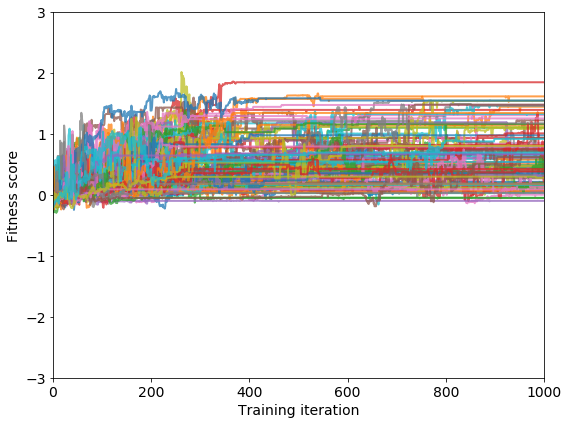

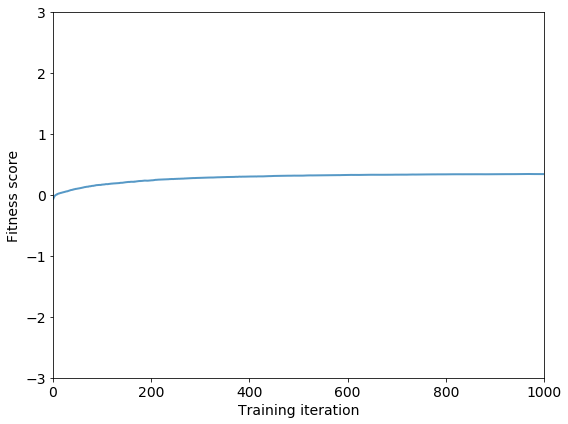

In [11]:
#Plot fitness statistics of optimization runs

#Plot k trajectories
plot_n_traj = 100

f = plt.figure(figsize=(8, 6))

for i in range(min(plot_n_traj, n_seqs)) :
    plt.plot(fitness_scores[i, :], linewidth=2, alpha=0.75)

plt.xlabel("Training iteration", fontsize=14)
plt.ylabel("Fitness score", fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.xlim(0, n_iters)
plt.ylim(-3, 3)

plt.tight_layout()
plt.show()

#Plot mean trajectory

f = plt.figure(figsize=(8, 6))

plt.plot(np.mean(fitness_scores, axis=0), linewidth=2, alpha=0.75)

plt.xlabel("Training iteration", fontsize=14)
plt.ylabel("Fitness score", fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.xlim(0, n_iters)
plt.ylim(-3, 3)

plt.tight_layout()
plt.show()


In [12]:
#Save sequences to file

with open(run_name + ".txt", "wt") as f :
    for i in range(len(seqs)) :
        seq = seqs[i]

        f.write(seq + "\n")
